# Visualization with plato
In this notebook, we run a Lennard-Jones simulation, color particles according to their local density, and display the results with [plato](https://github.com/glotzerlab/plato). Note that plato has multiple backends -- see the [plato documentation](http://plato-draw.readthedocs.io/) for information about each backend and the features it supports.

In [1]:
import hoomd
import hoomd.md
hoomd.context.initialize('')

# Create a 10x10x10 simple cubic lattice of particles with type name A
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.5, type_name='A'), n=10)

# Specify Lennard-Jones interactions between particle pairs
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

# Integrate at constant temperature
hoomd.md.integrate.mode_standard(dt=0.005)
integrator = hoomd.md.integrate.nvt(group=hoomd.group.all(), kT=0.01, tau=0.5)
integrator.randomize_velocities(seed=42)

# Run for 10,000 time steps
hoomd.run(10e3)
snap = system.take_snapshot()

HOOMD-blue 2.5.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/13/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 7763 / 10000 |

Now we import the modules needed for visualization.

In [8]:
import freud
import matplotlib.cm
import numpy as np
import plato
import plato.draw.fresnel as draw
from sklearn.preprocessing import minmax_scale

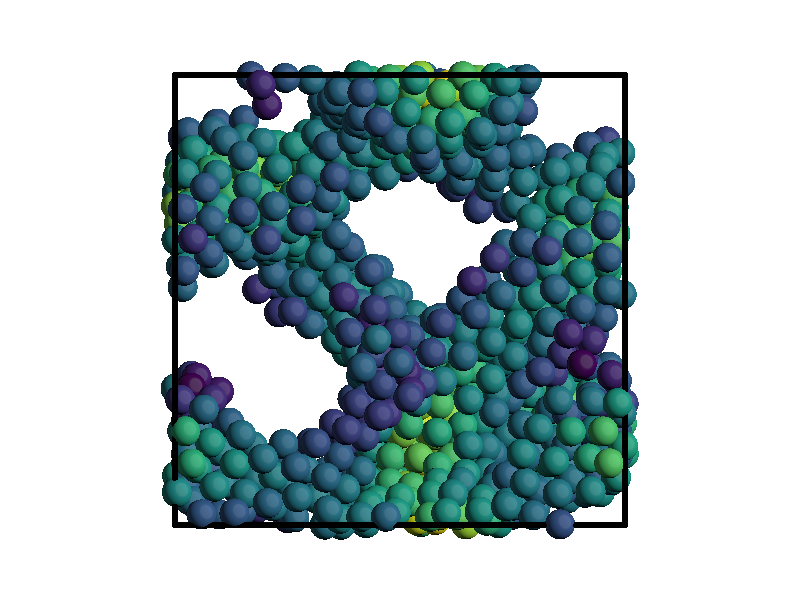

In [12]:
positions = snap.particles.position
box = freud.box.Box.from_box(snap.box)
ld = freud.density.LocalDensity(3.0, 1.0, 1.0)
ld.compute(box, positions)
colors = matplotlib.cm.viridis(minmax_scale(ld.density))
radii = np.ones(len(positions)) * 0.5
box_prim = draw.Lines(
    start_points=[box.makeCoordinates([0, 0, 0]),
                  box.makeCoordinates([0, 0, 0]),
                  box.makeCoordinates([0, 0, 0]),
                  box.makeCoordinates([1, 1, 0]),
                  box.makeCoordinates([1, 1, 0]),
                  box.makeCoordinates([1, 1, 0]),
                  box.makeCoordinates([0, 1, 1]),
                  box.makeCoordinates([0, 1, 1]),
                  box.makeCoordinates([0, 1, 1]),
                  box.makeCoordinates([1, 0, 1]),
                  box.makeCoordinates([1, 0, 1]),
                  box.makeCoordinates([1, 0, 1]),
                 ],
    end_points=[box.makeCoordinates([1, 0, 0]),
                box.makeCoordinates([0, 1, 0]),
                box.makeCoordinates([0, 0, 1]),
                box.makeCoordinates([1, 0, 0]),
                box.makeCoordinates([0, 1, 0]),
                box.makeCoordinates([1, 1, 1]),
                box.makeCoordinates([1, 1, 1]),
                box.makeCoordinates([0, 1, 0]),
                box.makeCoordinates([0, 0, 1]),
                box.makeCoordinates([0, 0, 1]),
                box.makeCoordinates([1, 1, 1]),
                box.makeCoordinates([1, 0, 0]),
               ],
    widths=0.2,
    colors=[[0, 0, 0, 1]]*12,
)
sphere_prim = draw.Spheres(
    positions=snap.particles.position,
    radii=radii,
    colors=colors,
    vertex_count=256)
scene = draw.Scene((sphere_prim, box_prim), zoom=1.5)
scene.show()